In [23]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn import tree



In [24]:
# functions
def remove_undesired_lengths(sequ, lower, upper):
    new = []
    for seq in sequ:
        if len(seq) > lower and len(seq) < upper:
            new.append(seq)
    return new

# functions
def length_list(sequ):
    output = []
    for seq in sequ:
        output.append(len(seq))
    return output


def get_chars(sequ):
    char = []
    for seq in sequ:
        for c in seq:
            if c not in char:
                char.append(c)
    return char

def encode_protseq(new_seq, values):
    encoded_sequence = [values[amino] for amino in new_seq]
    return encoded_sequence
def encode_df_column(frame, column, values):
    frame[column] = frame[column].apply(lambda seq: encode_protseq(seq, values))

def encode_df_column_binary(frame, column, value):
    frame[column] = frame[column].apply(lambda x: 1 if x == value else 0)

def remove_rows_by_string_length(frame, column_name, min_length, max_length):
    frame.drop(frame[(frame[column_name].str.len() < min_length) | (frame[column_name].str.len() > max_length)].index, inplace=True)


def split_list_column_inplace(frame, column_name):
    # Extract the column containing lists
    list_column = frame[column_name]

    # Create new columns for each element in the list
    max_list_length = list_column.apply(len).max()
    new_columns = [f"{column_name}_{i+1}" for i in range(max_list_length)]

    # Split the list into separate columns and add them to the same DataFrame
    frame[new_columns] = pd.DataFrame(list_column.tolist(), index=frame.index)

    # Drop the original list column inplace
    frame.drop(columns=[column_name], inplace=True)

In [25]:
#importing data
# extract data from tsv and put it in df
with open('C:/Users/loekd/OneDrive/Documenten/SearchTable-2024-02-06 12_24_08.532.tsv', 'r') as file:
    df = pd.read_csv(file, sep='\t')

# create a new df that only has if its TRA or TRB and cdr3 seq
rows = df[['Gene', "CDR3"]]
ndf = pd.DataFrame(rows)
# ndf = ndf.loc[ndf['CDR3'].str.len() == 15]
# delete old df to free up space
del df

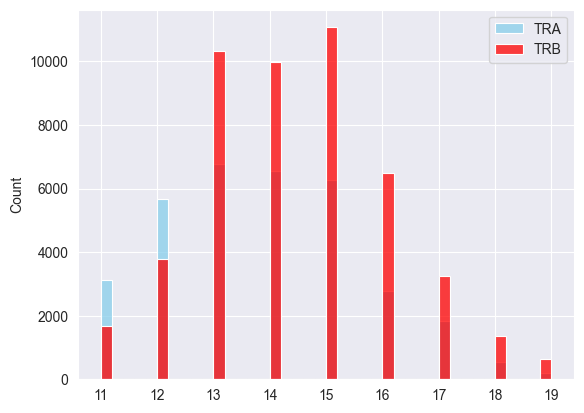

 TRA: 33699 TRB: 48600 


In [26]:
# # to create size distribution
# Extract the string for TRA
TRA_seq = []
for index, row in ndf.iterrows():
    if row['Gene'] == 'TRA':
        TRA_seq.append(row['CDR3'])

# extracting strings for TRB
TRB_seq = []
for index, row in ndf.iterrows():
    if row['Gene'] == 'TRB':
        TRB_seq.append(row['CDR3'])

# to weed out any undesired sequence lenghts
TRA_seq = remove_undesired_lengths(TRA_seq, 10, 20)
TRB_seq = remove_undesired_lengths(TRB_seq, 10, 20)

# to get list of sequence lengths
TRA_seq_len = length_list(TRA_seq)
TRB_seq_len = length_list(TRB_seq)

# Create a histogram
sns.histplot(TRA_seq_len, bins=40, kde=False, color='skyblue', label='TRA')
sns.histplot(TRB_seq_len, bins=40, kde=False, color='red', label='TRB')

plt.legend()
plt.plot()
plt.show()

print(f" TRA: {len(TRA_seq)} TRB: {len(TRB_seq)} ")

#create lists
seqs = ndf['CDR3'].tolist()
labels = ndf['Gene'].tolist()

In [27]:
# pre procesing
# protein encoding values
aa = ["L", "I", "N", "G", "V", "E", "P", "H", "K", "A", "Y", "W", "Q", "M", "S", "C", "T", "F", "R", "D"]
aa_encode = [
    "00000", "00001", "00010", "00011", "00100", "00101", "00110", "00111", "01000", "01001",
    "01010", "01011", "01100", "01101", "01110", "01111", "10000", "10001", "10010", "10011"
]
aa_encoding_series = pd.Series(aa_encode, index=aa)

# remove undesired lengths
remove_rows_by_string_length(ndf, 'CDR3', 15, 16)

# encoding columns
encode_df_column(ndf, 'CDR3', aa_encoding_series)
encode_df_column_binary(ndf, 'Gene', 'TRA')

split_list_column_inplace(ndf, 'CDR3')

In [28]:
# model
# Split the DataFrame into features (X) and target (y)
y = ndf['Gene']
X = ndf.drop('Gene', axis=1)

# modelling
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=50, max_depth=10, 
                             criterion='gini', 
                             max_leaf_nodes=None)

# Train the classifier on the training data
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, n_estimators=50)

In [29]:
# # Hyperparameter tuning
# param_dist = {'n_estimators': randint(50,500),
#               'max_depth': randint(1,20)}
# # Use random search to find the best hyperparameters
# rand_search = RandomizedSearchCV(clf, 
#                                  param_distributions = param_dist, 
#                                  n_iter=5, 
#                                  cv=5)
# 
# # Fit the random search object to the data
# rand_search.fit(X_train, y_train)
# 
# # Create a variable for the best model
# best_rf = rand_search.best_estimator_
# 
# # Print the best hyperparameters
# print('Best hyperparameters:',  rand_search.best_params_)

Accuracy: 0.9983069977426636
Precision: 0.9972840847365562
Recall:0.9978260869565218


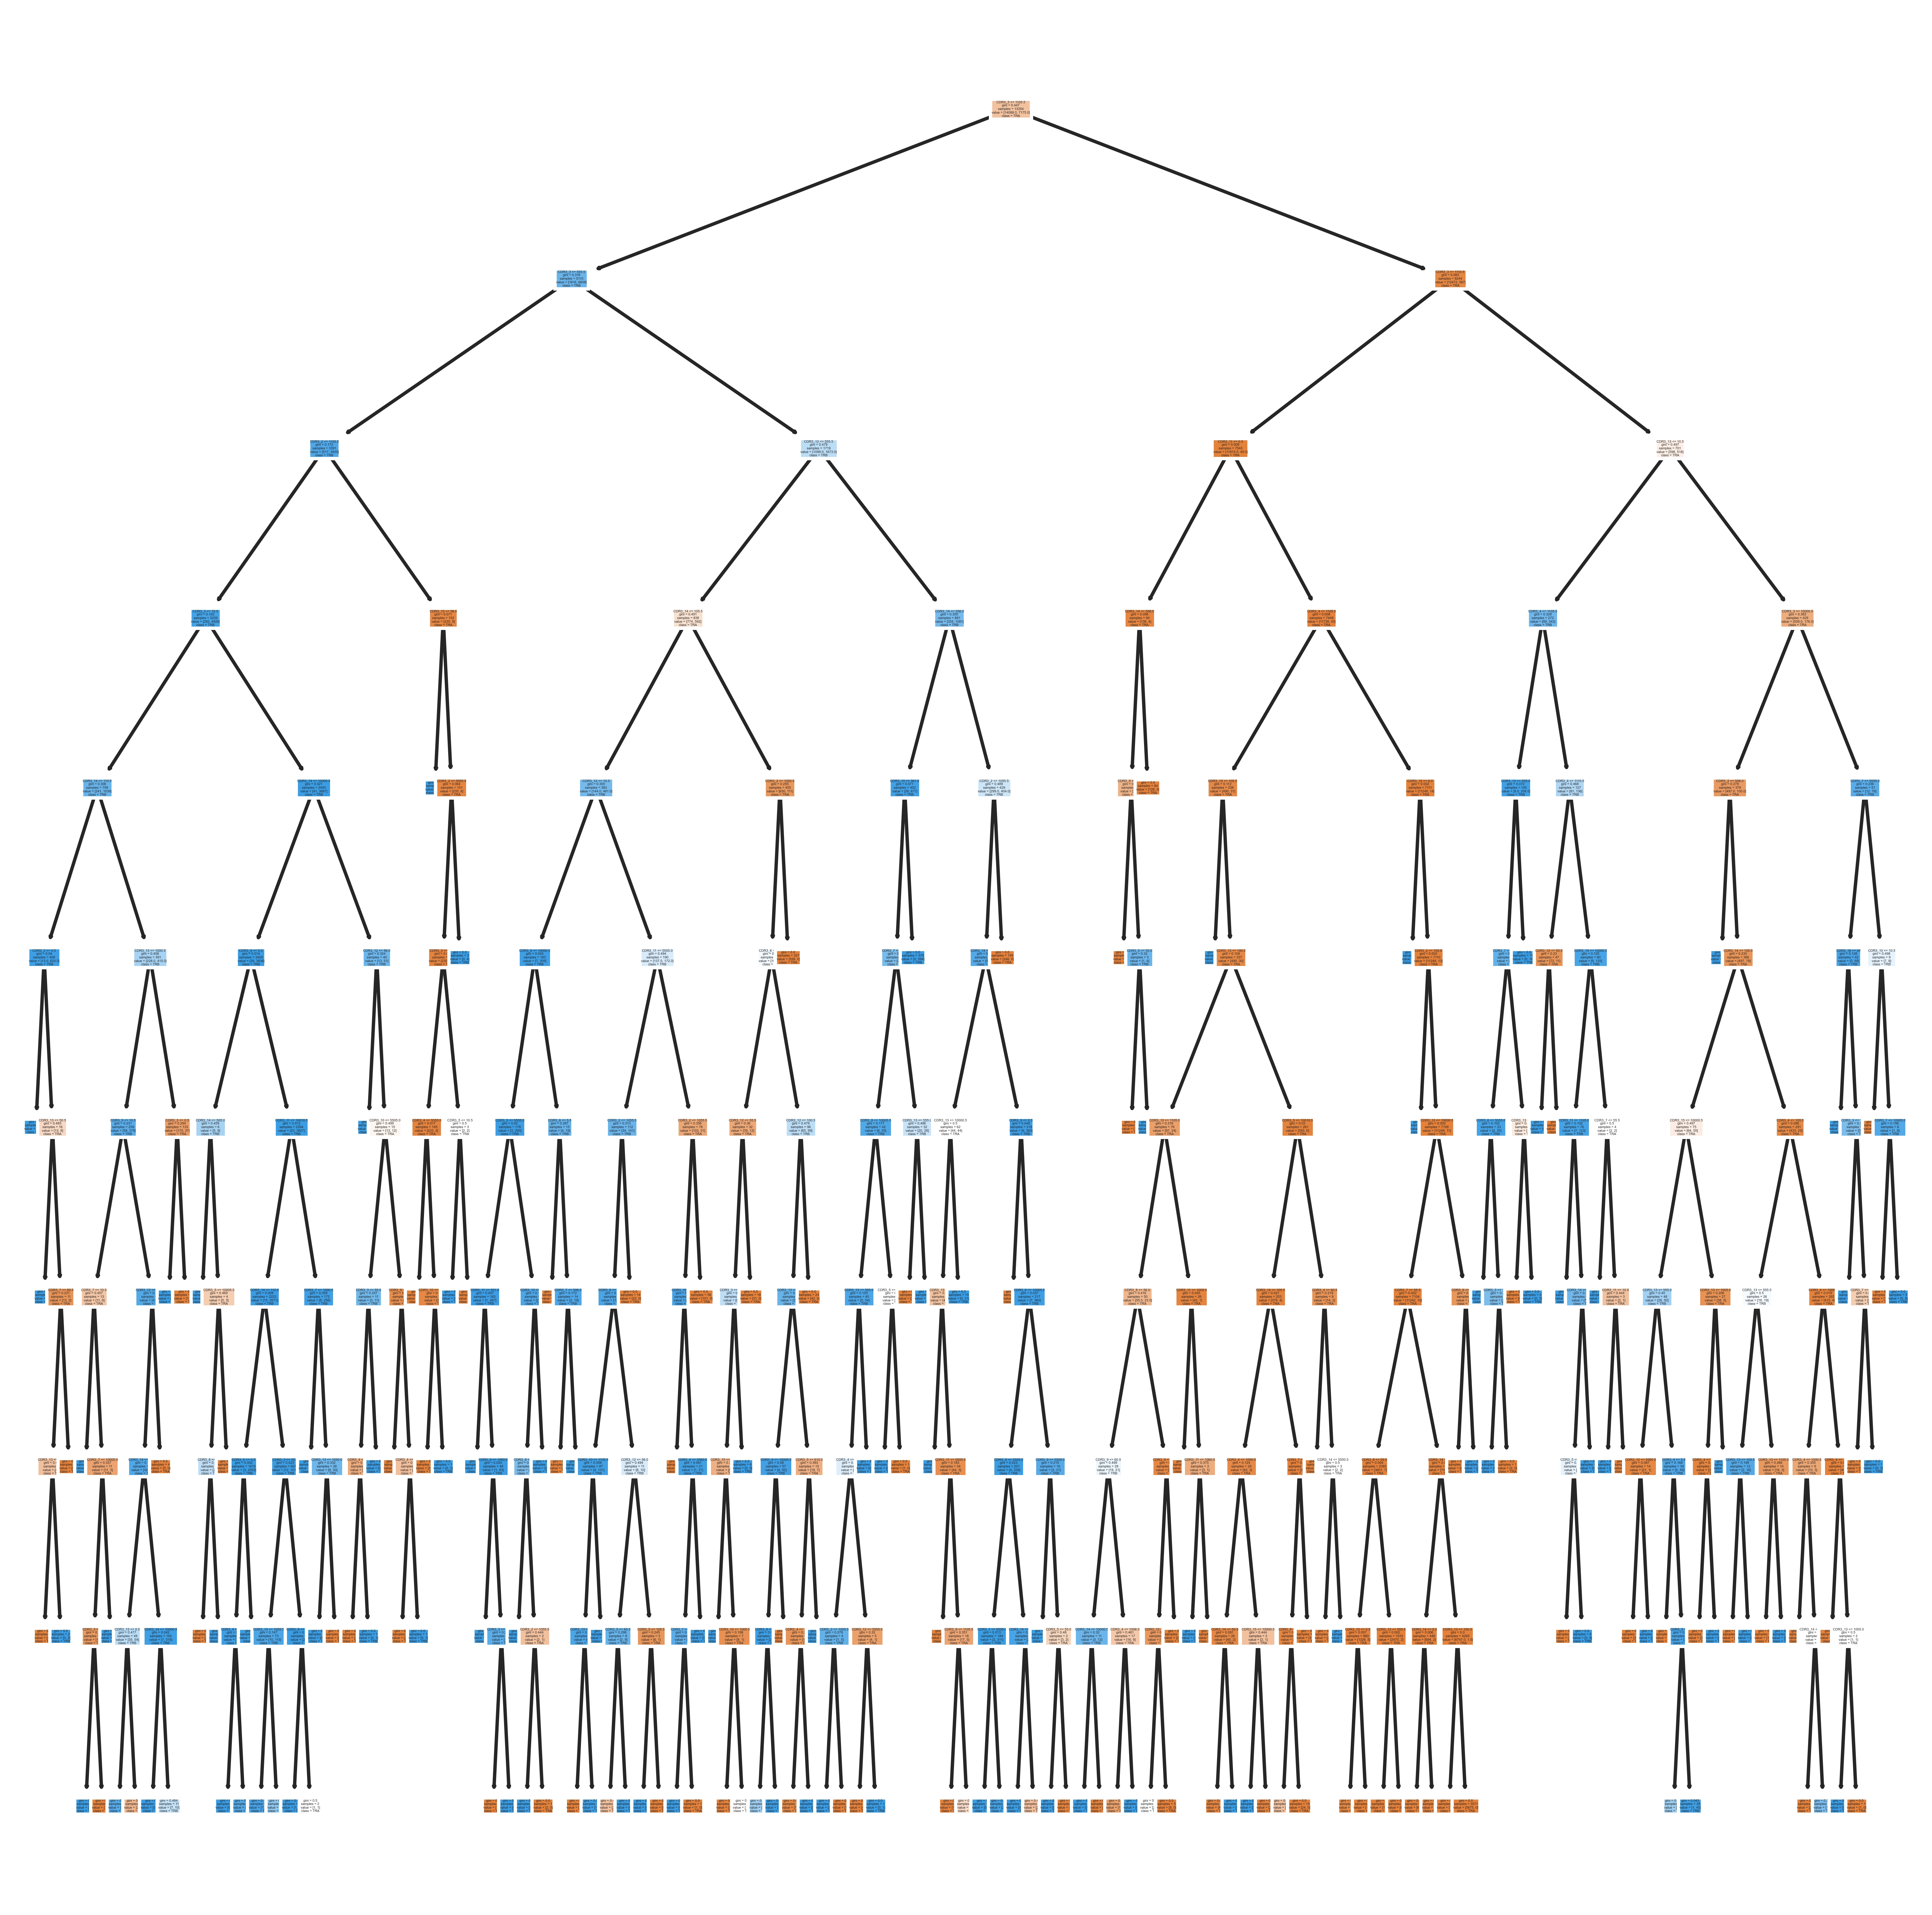

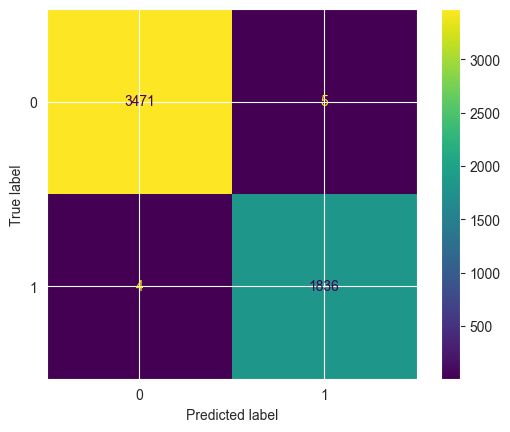

In [30]:
# evaluation

# for evaluation
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall:{recall}")

# making tree visualisations
# labeling
fn = X.columns
cn = ['TRA', 'TRB']

# creating figure
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), dpi=800)
tree.plot_tree(clf.estimators_[0], 
               feature_names=fn, 
               class_names=cn, 
               filled=True)
fig.savefig('plots/trees_nr1.png')

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()



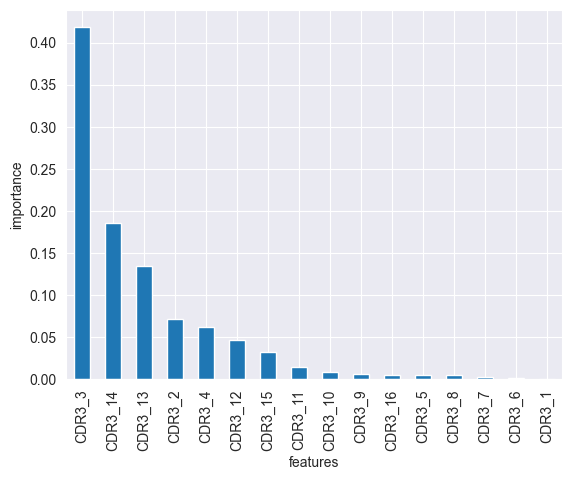

In [31]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
# Plot a simple bar chart
ax = feature_importances.plot.bar()
ax.set_xlabel('features')
ax.set_ylabel('importance')
plt.savefig('plots/feature_importancelen15TRATRB.png', bbox_inches='tight')

0.9999939022864861


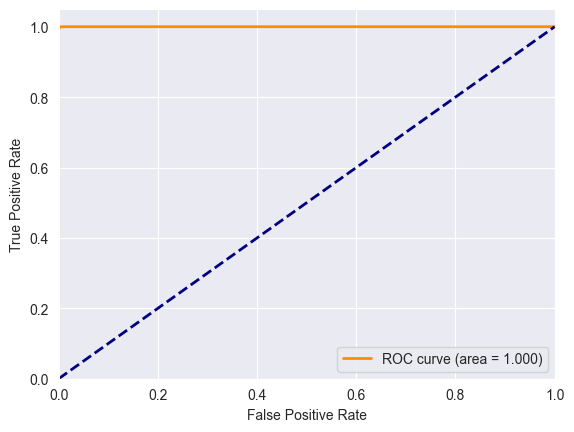

In [32]:
# roc curve
# Predict probabilities
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability of being in the positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)
print(roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('plots/TRATRB_ROC.png', bbox_inches='tight')